In [12]:
import yfinance as yf
import pandas as pd
import datetime
from prophet import Prophet

 Использую библиотеки yafinance для формирования выборки, что бы не вводить даты использую datetime today и delta 365 дней


In [13]:
end_365 = datetime.date.today() + datetime.timedelta(days=1)
start_365 = end_365 - datetime.timedelta(days=365)

data = yf.download("EURRUB=X", start = start_365.isoformat(), end = end_365.isoformat())


[*********************100%***********************]  1 of 1 completed


In [14]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-29 00:00:00+01:00,54.529202,55.341202,54.529202,54.529202,54.529202,0
2022-09-30 00:00:00+01:00,55.341202,56.449402,55.341202,55.341202,55.341202,0
2022-10-03 00:00:00+01:00,56.449402,56.627602,56.449402,56.449402,56.449402,0
2022-10-04 00:00:00+01:00,56.627602,57.857399,56.627602,56.627602,56.627602,0
2022-10-05 00:00:00+01:00,58.866199,60.153000,57.852798,59.931000,59.931000,0


Меняю индекс (пока индексом является дата)

In [15]:
data = data.reset_index()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-06 00:00:00+01:00,83.836098,84.013603,83.502998,83.860901,83.860901,0
1,2021-10-07 00:00:00+01:00,83.691101,83.752197,82.869400,83.687897,83.687897,0
2,2021-10-08 00:00:00+01:00,83.030998,83.308998,82.827499,83.010498,83.010498,0
3,2021-10-11 00:00:00+01:00,83.136703,83.212097,82.737000,82.993698,82.993698,0
4,2021-10-12 00:00:00+01:00,83.080299,83.156998,82.833199,83.065201,83.065201,0


Пропуски отсутствуют, выходных дней так же нет в данных

In [16]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Добавляю необходимые колонки для использования Prophet

In [17]:
data['ds'] = pd.to_datetime(data['Date']).dt.date.astype('datetime64[ns]')
data['y'] = (data.High + data.Low)/2

Выбираю нужные колонки

In [18]:
df = data[['ds','y']]
df.head()

,ds,y
0,2021-10-06,83.758301
1,2021-10-07,83.310799
2,2021-10-08,83.068249
3,2021-10-11,82.974548
4,2021-10-12,82.995098


Создаю экземпляр класса Prophet
Вызываю метод fit - обучается на текущих данных

In [19]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.02548
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       514.021     0.0310668         169.7      0.2297           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       514.097   0.000955966       82.6695   5.633e-06       0.001      166  LS failed, Hessian reset 
     120       514.801   0.000749653       88.7949    7.01e-06       0.001      226  LS failed, Hessian reset 
     170        514.92   0.000399752       60.6966   5.955e-06       0.001      335  LS failed, Hessian reset 
     199       514.941   9.06896e-06       72.4911           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       514.947   5.63623e-07        62.444   7.246e-09       0.001      485  LS failed, Hessian reset 
     260       514.947   3.13394e-08       53.4348      0.2375   

/Users/andrejmironov/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Выбираю период, добавляем в df, точнее количество дней (т.к. комментарий добавляю 05.10, а код строил таким образом, что бы не нужно было вводить данные - автоматом рассчитывалось T+1), предсказывать будем на 06.10.
На 05.10 предсказывал 56.041162	руб.

Зададим нужный период i

In [20]:
i = 1

In [21]:
future = m.make_future_dataframe(periods=i)
future.tail()

,ds
257,2022-09-30
258,2022-10-03
259,2022-10-04
260,2022-10-05
261,2022-10-06


Предсказываем, доверительный интервал, в том числе.
Верхня и нижняя границы +-12. Существенные отклонения возможны.

In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/andrejmironov/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/andrejmironov/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
257,2022-09-30,56.395346,44.852776,68.370154
258,2022-10-03,57.031599,44.767232,68.377247
259,2022-10-04,56.615886,44.985490,69.063051
260,2022-10-05,56.322943,44.176860,67.779518
261,2022-10-06,56.241116,43.748221,69.308391


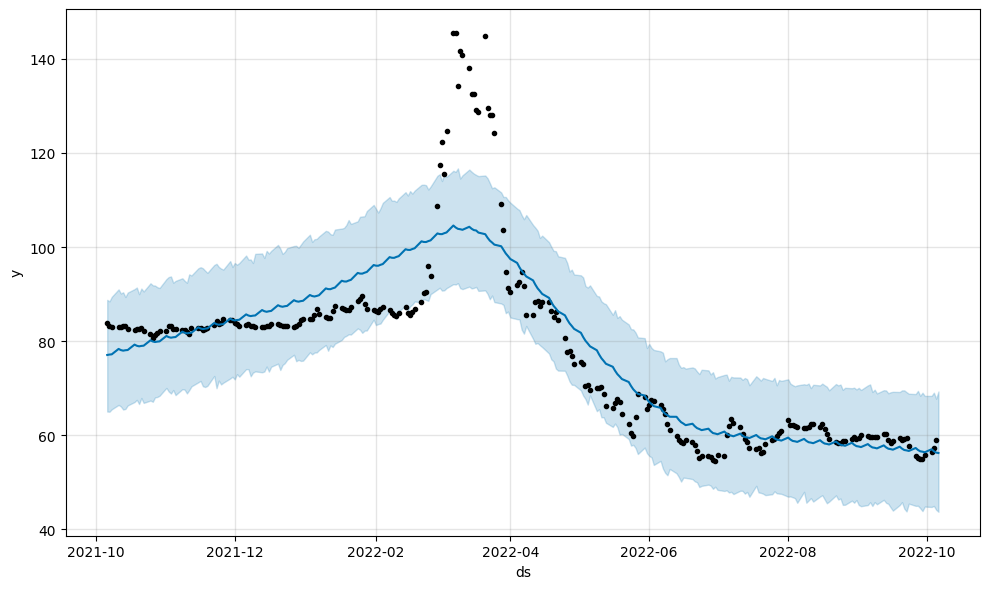

In [23]:
fig1 = m.plot(forecast)